<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/english/machine_learning/lessons/o_x.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of hand written simple markers

Let's try to make model for "o" and "x" marker classification.

Let's create a CNN to recognize X or O shapes in a 9 x 9 pixel image and visualize convolutional filters and filtered images.

##Preprocessing of input image

During preprocessing the large input image is cutted into individual symbols. The lines are widened and symbols are scaled and downsampled.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.filters import threshold_otsu
from skimage.transform import resize
from skimage.morphology import erosion, convex_hull_image
from skimage.util import invert
from sklearn.model_selection import train_test_split

In [13]:
# some constants
image_size = 32                 # target size of sub images in pixel (square shaped)
train_start = 0
train_rows = 16
train_cols = 10
train_num = train_rows * train_cols
size = 177                      # original size of a marker
border = 10                     # cut border around marker
margin = 6                      # left margin
labels = ["circle", "cross"]

In [14]:
!wget -q -O o_x.png https://github.com/OSGeoLabBp/tutorials/blob/master/english/machine_learning/lessons/data/o_x.png?raw=true

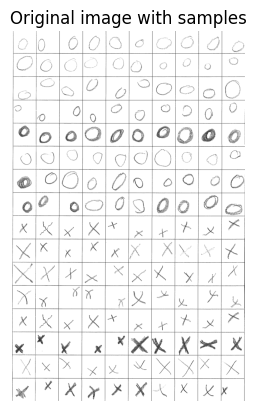

In [4]:
# load all train and test data as one image
img = imread('o_x.png', as_gray=True)     # read image as gray
#thresh = threshold_otsu(img)
#img = (img > thresh).astype('int8')       # convert binary
plt.axis("off")
plt.imshow(img, cmap='gray')
_ = plt.title("Original image with samples")

The next block demonstrate the process of a single cell.

10 167 16 167


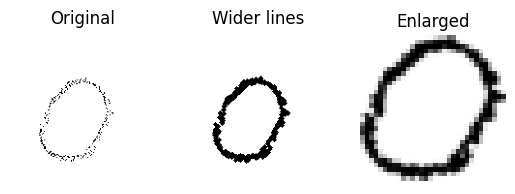

In [ ]:
# preprocessing of individual cells
pixel_top = train_start * size + border
pixel_bot = (train_start + 1) * size - border
pixel_left = margin + 0 * size + border
pixel_righ = (0 + 1) * size - border
print(pixel_top, pixel_bot, pixel_left, pixel_righ)
sub_img = img[pixel_top:pixel_bot,pixel_left:pixel_righ]    # content of a cell
sub_img1 = erosion(erosion(sub_img))                        # remove white pixels around lines
thresh = threshold_otsu(sub_img1)                           # threshold to convert binary image
sub_img2 = (sub_img1 > thresh).astype('uint8')              # convert binary
sub_img3 = invert(sub_img2) - 254
indx = np.nonzero(sub_img3)                                 # find bounding box of symbol
sub_row0, sub_row1 = np.min(indx[0]), np.max(indx[0]+1)
sub_col0, sub_col1 = np.min(indx[1]), np.max(indx[1]+1)
sub_img4 = resize(sub_img2[sub_row0:sub_row1, sub_col0:sub_col1], (image_size, image_size))
fig, (ax0, ax1, ax4) = plt.subplots(1, 3)
ax0.imshow(sub_img, cmap='gray')
ax0.set_title("Original")
ax0.axis("off")
ax1.imshow(sub_img1, cmap='gray')
ax1.set_title("Wider lines")
ax1.axis("off")
ax4.imshow(sub_img4, cmap='gray')
ax4.set_title("Enlarged")
_ = ax4.axis("off")

Preprocess all symbols

In [5]:
# training and test data
X = np.zeros((train_num, image_size, image_size, 1), dtype='float32')
y = np.zeros(train_num, dtype='float32')
y[train_num // 2:] = 1              # first half "o"/0, seconf half "x"/1

In [ ]:
# create individual images
k = 0
for i in range(train_start, train_start + train_rows):     # rows
    pixel_top = i * size + border
    pixel_bot = (i + 1) * size - border
    for j in range(10): # columns
        pixel_left = margin + j * size + border
        pixel_righ = (j + 1) * size - border
        sub_img = erosion(erosion(img[pixel_top:pixel_bot,pixel_left:pixel_righ]))
        thresh = threshold_otsu(sub_img)
        sub_img = (sub_img > thresh).astype('uint8')
        inv = invert(sub_img) - 254
        indx = np.nonzero(inv)
        sub_row0, sub_row1 = np.min(indx[0]), np.max(indx[0]+1)
        sub_col0, sub_col1 = np.min(indx[1]), np.max(indx[1]+1)
        X[k] = np.expand_dims(resize(sub_img[sub_row0:sub_row1, sub_col0:sub_col1], (image_size, image_size)), -1)
        k += 1

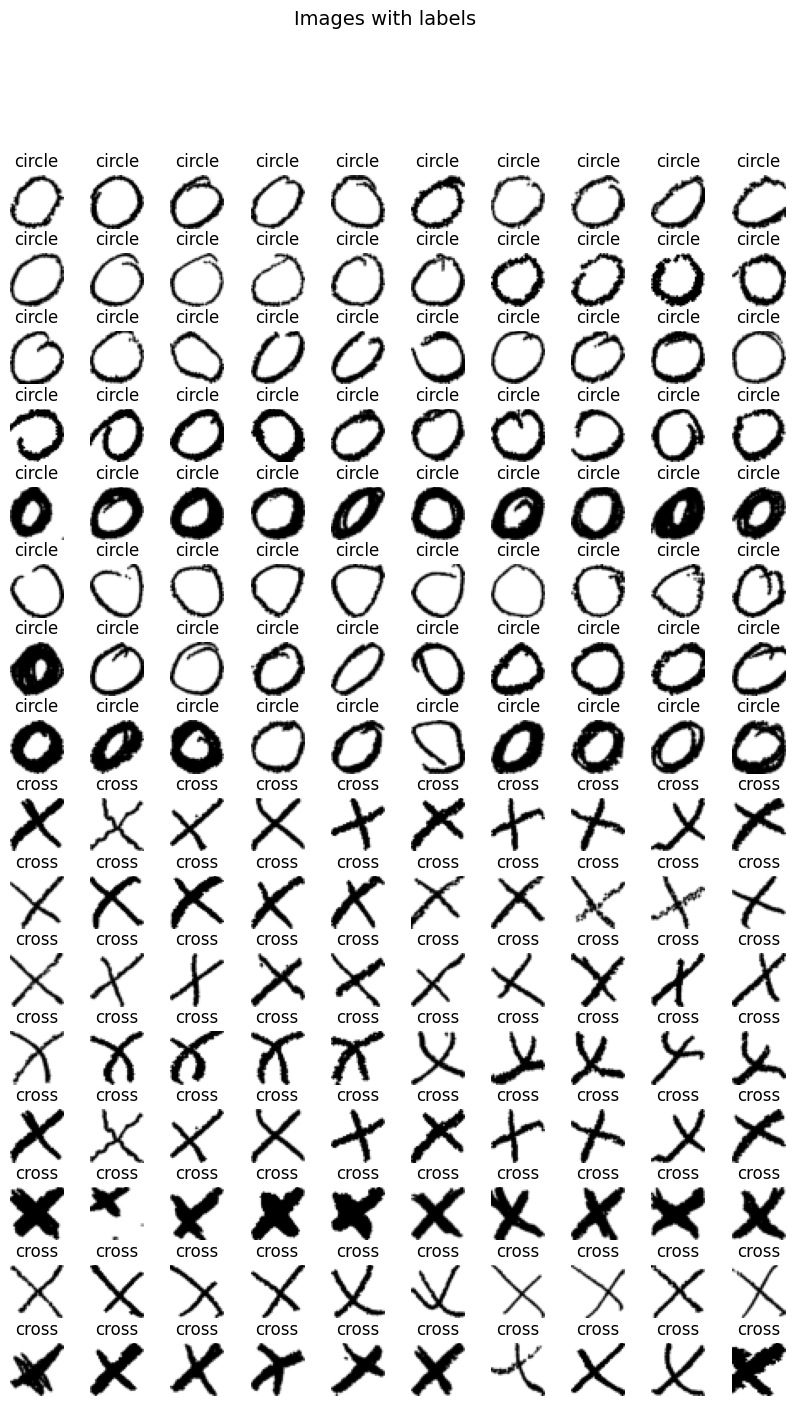

In [ ]:
# show train images
fig, ax = plt.subplots(train_rows, train_cols, figsize=(train_cols, train_rows))
fig.suptitle('Images with labels', fontsize=14)
ax = ax.ravel()
for i in range(train_rows * train_cols):
    ax[i].imshow(X[i], cmap='gray')
    ax[i].set_title(labels[int(y[i])])
    ax[i].axis('off')
plt.subplots_adjust(wspace=0.5)

##Support Vector Machine

Model built using *scikit-learn* SVM.

In [ ]:
from sklearn import svm
from sklearn import metrics
#from sklearn.manifold import TSNE
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [ ]:
# preparing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
XX_train = np.zeros((X_train.shape[0], image_size * image_size), dtype='float32')
XX_test = np.zeros((X_test.shape[0], image_size * image_size), dtype='float32')
for i in range(X_train.shape[0]):
    XX_train[i] = X_train[i].reshape(image_size * image_size)
for i in range(X_test.shape[0]):
    XX_test[i] = X_test[i].reshape(image_size * image_size)

In [ ]:
XX_train.shape,X.shape

((112, 1024), (160, 32, 32, 1))

In [ ]:
# hyper parameter estimation
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = [{'C': C_range, 'gamma': gamma_range, 'kernel': ['linear', 'poly', 'rbf']}]
base_estimator = svm.SVC()
sh = HalvingGridSearchCV(base_estimator, param_grid, cv=3,
                         factor=2,
                         max_resources=30).fit(XX_train, y_train)
sh.best_params_

{'C': 10000000.0, 'gamma': 1e-05, 'kernel': 'rbf'}

In [ ]:
sh.best_estimator_

SVC(C=10000000.0, gamma=1e-05)

In [ ]:
clf = sh.best_estimator_
clf.fit(XX_train, y_train)
y_test_pred = clf.predict(XX_test)
y_train_pred = clf.predict(XX_train)
print(f"Accuracy (test/train): {metrics.accuracy_score(y_test, y_test_pred):.1%} / {metrics.accuracy_score(y_train, y_train_pred):.1%}")

Accuracy (test/train): 100.0% / 99.1%


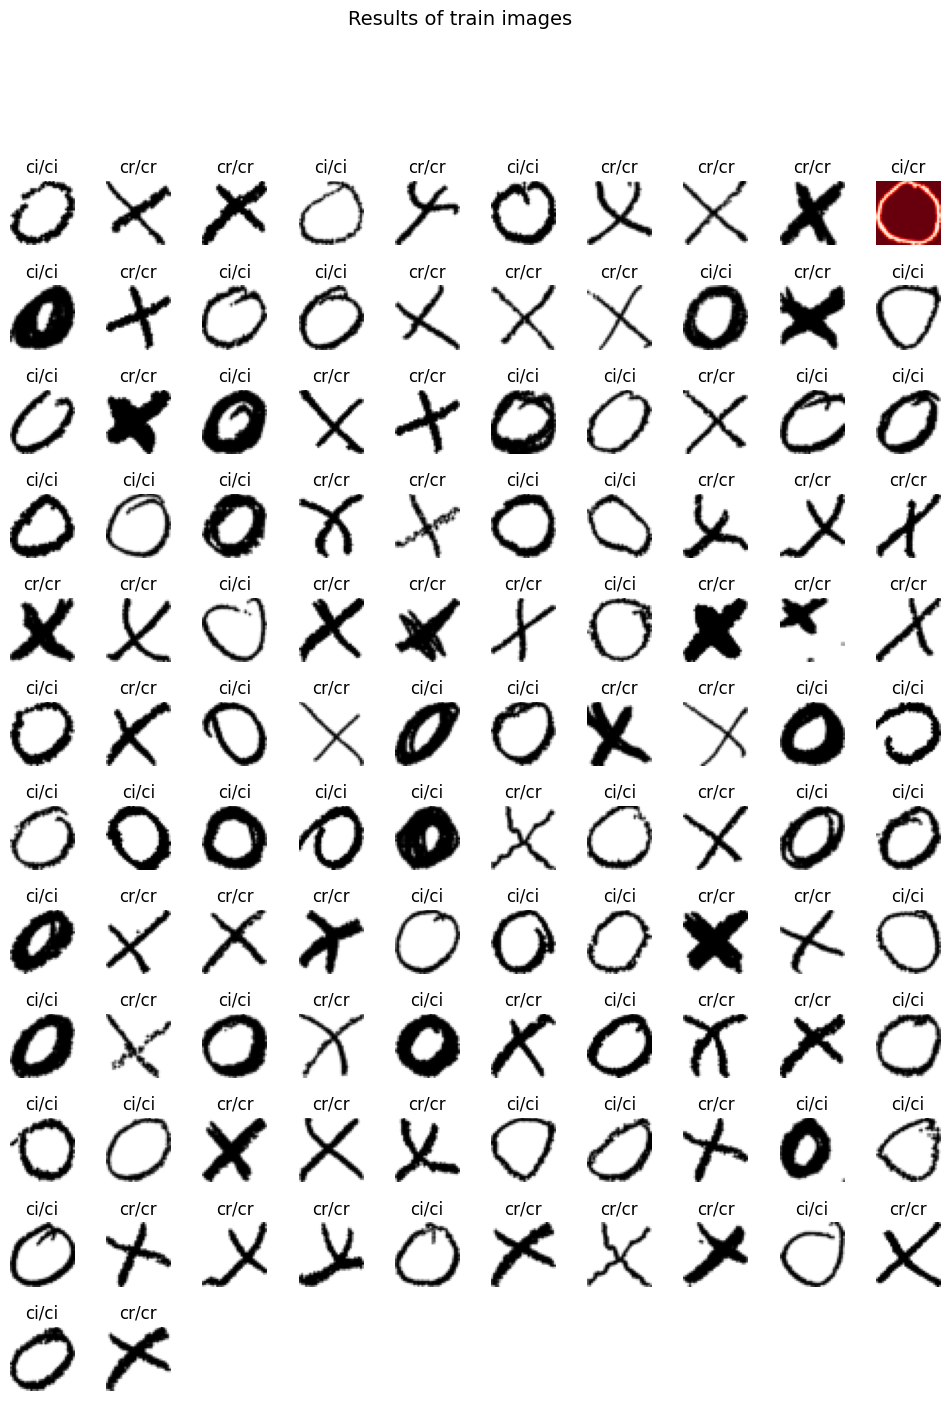

In [ ]:
# show train images
fig, ax = plt.subplots(X_train.shape[0]//train_cols+1, train_cols, figsize=(XX_train.shape[0]//train_cols+1, train_rows))
fig.suptitle('Results of train images', fontsize=14)
ax = ax.ravel()
for a in ax:
    a.axis("off")       # turn off axis on all subplots

for i in range(X_train.shape[0]):
    cmap = 'gray' if int(y_train[i]) == int(y_train_pred[i]) else 'Reds'
    ax[i].imshow(X_train[i], cmap=cmap)
    ax[i].set_title(f"{labels[int(y_train[i])][:2]}/{labels[int(y_train_pred[i])][:2]}")
plt.subplots_adjust(wspace=0.5)

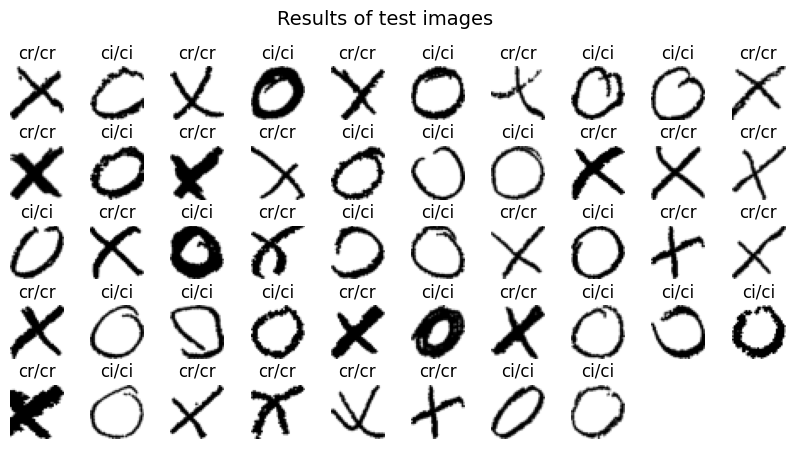

In [ ]:
# show train images
fig, ax = plt.subplots(X_test.shape[0]//train_cols+1, train_cols, figsize=(train_cols, X_test.shape[0]//train_cols+1))
fig.suptitle('Results of test images', fontsize=14)
ax = ax.ravel()
for a in ax:
    a.axis("off")       # turn off axis on all subplots

for i in range(X_test.shape[0]):
    cmap = 'gray' if int(y_test[i]) == int(y_test_pred[i]) else 'Reds'
    ax[i].imshow(X_test[i], cmap=cmap)
    ax[i].set_title(f"{labels[int(y_test[i])][:2]}/{labels[int(y_test_pred[i])][:2]}")
plt.subplots_adjust(wspace=0.5)

## Preparation for CNN

Keep gray images



In [15]:
# create individual images
k = 0
for i in range(train_start, train_start + train_rows):     # rows
    pixel_top = i * size + border
    pixel_bot = (i + 1) * size - border
    for j in range(10): # columns
        pixel_left = margin + j * size + border
        pixel_righ = (j + 1) * size - border
        #sub_img = erosion(erosion(img[pixel_top:pixel_bot,pixel_left:pixel_righ]))
        sub_img = img[pixel_top:pixel_bot,pixel_left:pixel_righ]
        #thresh = threshold_otsu(sub_img)
        #sub_img = (sub_img > thresh).astype('uint8')
        sub_img = invert(sub_img)
        indx = np.nonzero(sub_img)
        sub_row0, sub_row1 = np.min(indx[0]), np.max(indx[0]+1)
        sub_col0, sub_col1 = np.min(indx[1]), np.max(indx[1]+1)
        #X[k] = resize(sub_img[sub_row0:sub_row1, sub_col0:sub_col1], (image_size, image_size))
        X[k] = np.expand_dims(resize(sub_img[sub_row0:sub_row1, sub_col0:sub_col1], (image_size, image_size)), -1)
        k += 1

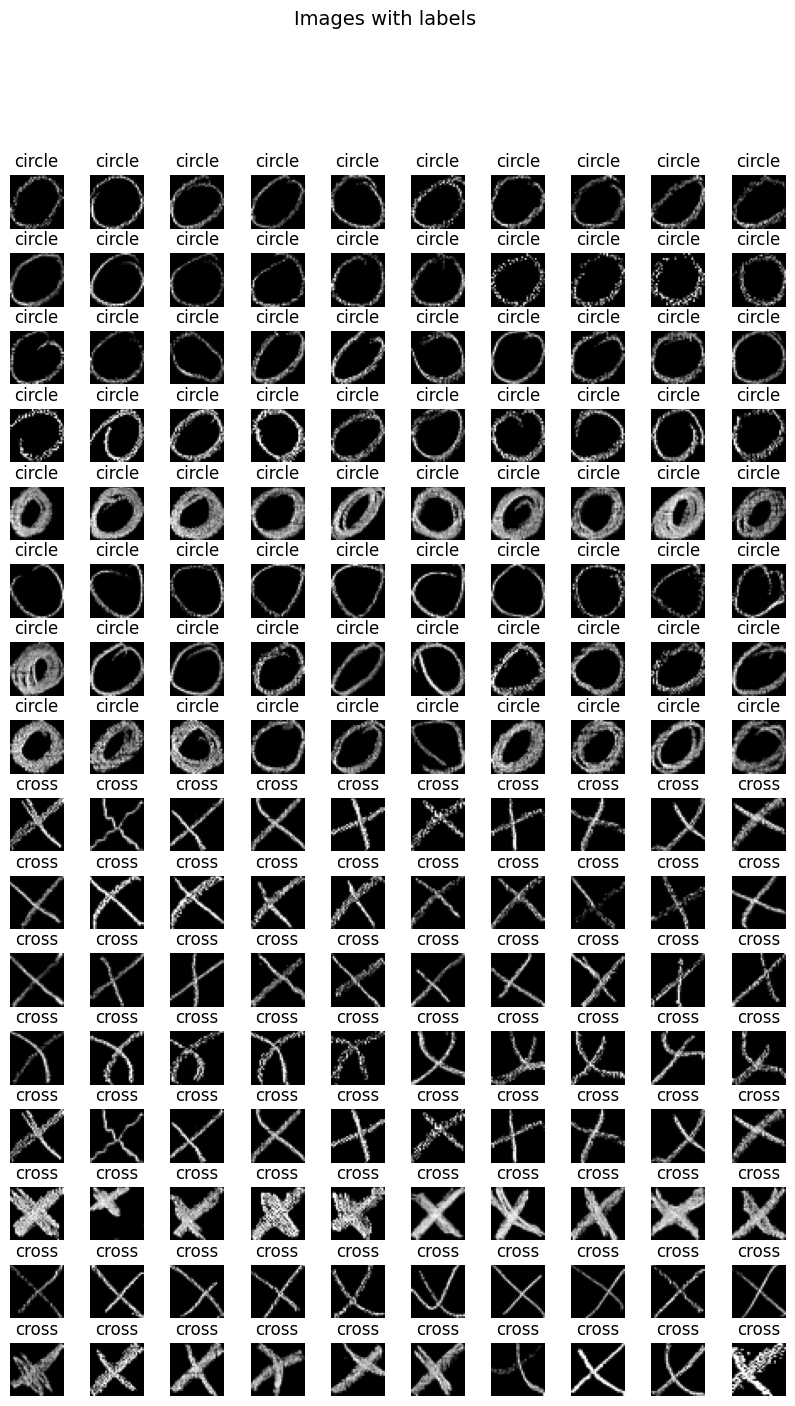

In [9]:
# show train images
fig, ax = plt.subplots(train_rows, train_cols, figsize=(train_cols, train_rows))
fig.suptitle('Images with labels', fontsize=14)
ax = ax.ravel()
for i in range(train_rows * train_cols):
    ax[i].imshow(X[i], cmap='gray')
    ax[i].set_title(labels[int(y[i])])
    ax[i].axis('off')
plt.subplots_adjust(wspace=0.5)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [17]:
y_train.shape, y_train.dtype

((112,), dtype('float32'))

In [19]:
from keras.utils import to_categorical

In [21]:
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

In [22]:
y_train.shape, y_train.dtype

((112, 2), dtype('float32'))

## Convolutional Neural Network

A model is built using *keras*.

In [23]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.losses import mean_squared_error
from keras.utils import img_to_array
from keras.optimizers import SGD

In [ ]:
# building the model
model = Sequential()
model.add(Conv2D(8, (3, 3), padding='same', input_shape=(image_size, image_size, 1), activation='relu', kernel_initializer='variance_scaling'))
#model.add(Conv2D(8, (3, 3), padding='same', activation='relu', kernel_initializer='variance_scaling'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#model.add(Dropout(0.2))
model.add(Conv2D(16, (3, 3), padding='same', activation='relu', kernel_initializer='variance_scaling'))
#model.add(Conv2D(16, (3, 3), padding='same', activation='relu', kernel_initializer='variance_scaling'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax', kernel_initializer='variance_scaling'))
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss=mean_squared_error, metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 8)         80        
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 16, 16, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 16)        1168      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 8, 8, 16)          0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 64)               

In [24]:
# define cnn model (used for MNIST)
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
# compile model
opt = SGD(learning_rate=0.01, momentum=0.9)
#model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dropout (Dropout)           (None, 2304)              0

In [51]:
# minimalist model
model = Sequential()
model.add(Conv2D(8, (3, 3), activation='relu', input_shape=(image_size, image_size, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
# compile model
opt = SGD(learning_rate=0.01, momentum=0.9)
#model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 8)         80        
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 15, 15, 8)         0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 1800)              0         
                                                                 
 dropout_3 (Dropout)         (None, 1800)              0         
                                                                 
 dense_3 (Dense)             (None, 2)                 3602      
                                                                 
Total params: 3682 (14.38 KB)
Trainable params: 3682 (14.38 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [52]:
%%time
epochs = 15
history = model.fit(X_train, y_train, batch_size=16, epochs=epochs, validation_data=(X_test, y_test), shuffle=True)

Epoch 1/15
7/7 [==============================] - 1s 67ms/step - loss: 0.2354 - accuracy: 0.6429 - val_loss: 0.2223 - val_accuracy: 0.7917
Epoch 2/15
7/7 [==============================] - 0s 19ms/step - loss: 0.1816 - accuracy: 0.8929 - val_loss: 0.1498 - val_accuracy: 0.9583
Epoch 3/15
7/7 [==============================] - 0s 23ms/step - loss: 0.1029 - accuracy: 0.9821 - val_loss: 0.0824 - val_accuracy: 1.0000
Epoch 4/15
7/7 [==============================] - 0s 21ms/step - loss: 0.0532 - accuracy: 1.0000 - val_loss: 0.0427 - val_accuracy: 1.0000
Epoch 5/15
7/7 [==============================] - 0s 22ms/step - loss: 0.0337 - accuracy: 0.9911 - val_loss: 0.0237 - val_accuracy: 1.0000
Epoch 6/15
7/7 [==============================] - 0s 29ms/step - loss: 0.0189 - accuracy: 1.0000 - val_loss: 0.0157 - val_accuracy: 1.0000
Epoch 7/15
7/7 [==============================] - 0s 18ms/step - loss: 0.0155 - accuracy: 0.9911 - val_loss: 0.0116 - val_accuracy: 1.0000
Epoch 8/15
7/7 [===========

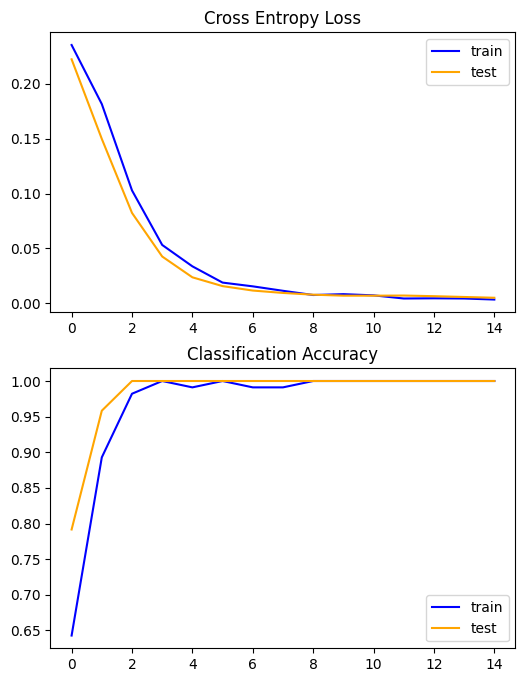

In [53]:
# plot diagnostic learning curves and optionaly save to file
def summarize_diagnostics(history, filename=None):
    # if file name given curves are saved to file and not displayed on screen
    fig, ax = plt.subplots(2, 1, figsize=(6, 8))
    ax[0].set_title('Cross Entropy Loss')
    ax[0].plot(history.history['loss'], color='blue', label='train')
    ax[0].plot(history.history['val_loss'], color='orange', label='test')
    ax[0].legend()
    # plot accuracy
    ax[1].set_title('Classification Accuracy')
    ax[1].plot(history.history['accuracy'], color='blue', label='train')
    ax[1].plot(history.history['val_accuracy'], color='orange', label='test')
    ax[1].legend(loc=4)
    plt.subplots_adjust(wspace=0.5)
    if filename:
        # save plot to file
        pyplot.savefig(filename + '_plot.png')
        pyplot.close()

summarize_diagnostics(history)

In [54]:
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)
pred_test_classes = np.argmax(y_pred_test, axis=1)
pred_train_classes = np.argmax(y_pred_train, axis=1)

4/4 [==============================] - 0s 9ms/step


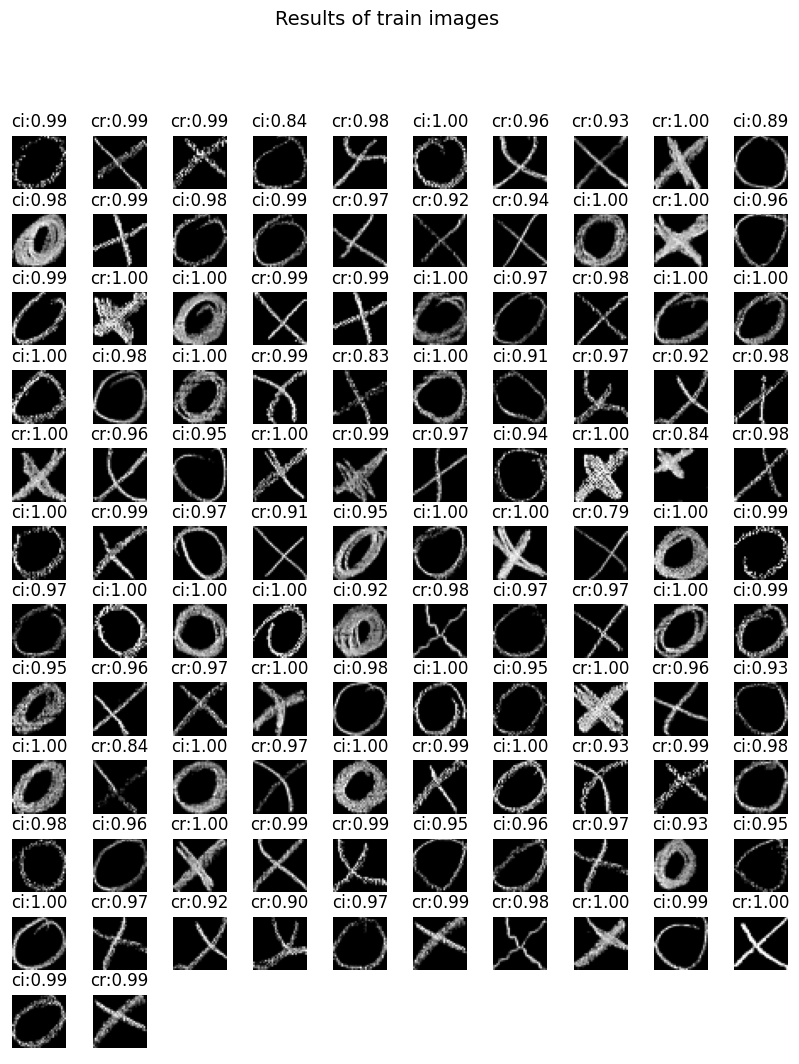

In [55]:
# show train images
fig, ax = plt.subplots(X_train.shape[0]//train_cols+1, train_cols, figsize=(train_cols, X_train.shape[0]//train_cols+1))
fig.suptitle('Results of train images', fontsize=14)
ax = ax.ravel()
for a in ax:
    a.axis("off")       # turn off axis on all subplots

for i in range(X_train.shape[0]):
    cls = pred_train_classes[i]     # 0/1
    val = y_pred_train[i, cls]
    cmap = 'gray' if y_train[i, cls] == 1 else 'Reds'
    ax[i].imshow(X_train[i], cmap=cmap)
    ax[i].set_title(f"{labels[int(cls)][:2]}:{val:.2f}")
    #ax[i].axis('off')
plt.subplots_adjust(wspace=0.5)

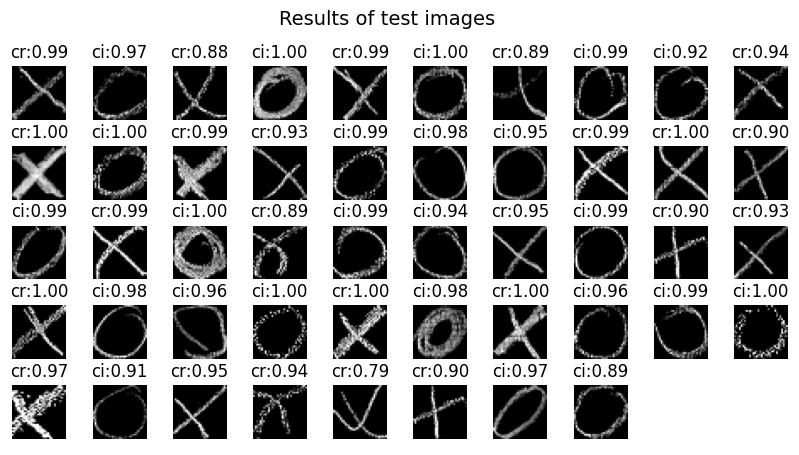

In [50]:
# show test images
fig, ax = plt.subplots(X_test.shape[0]//train_cols+1, train_cols, figsize=(train_cols, X_test.shape[0]//train_cols+1))
fig.suptitle('Results of test images', fontsize=14)
ax = ax.ravel()
for a in ax:
    a.axis("off")       # turn off axis on all subplots

for i in range(X_test.shape[0]):
    cls = pred_test_classes[i]     # 0/1
    val = y_pred_test[i, cls]
    cmap = 'gray' if y_test[i, cls] == 1 else 'Reds'
    ax[i].imshow(X_test[i], cmap=cmap)
    ax[i].set_title(f"{labels[int(cls)][:2]}:{val:.2f}")
    #ax[i].axis('off')
plt.subplots_adjust(wspace=0.5)